In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tabulate import tabulate
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#cand_data_list = ['svm','test_accuracies','train_accuracies','test_losses','variances']

def confirm_ts_dir(dir_path):
    dir_list = os.listdir(dir_path)
    confirm = False
    for name in dir_list:
        if 'ckpt' in name:
            confirm = True
            break
    return confirm

def parse_dirs(base_dir):
    base_dir 
    base_dir_list = os.listdir(base_dir)
    s_dir_path = None
    t_dir_path = None  
    if any('ckpt' in name for name in base_dir_list):
        if any('loop_1' in name for name in base_dir_list):
            s_dir_path = base_dir
        else:
            t_dir_path = base_dir
    else:
        for name in base_dir_list:
            if 'teacher' in name:
                dir_path = os.path.join(base_dir,name)
                if confirm_ts_dir(dir_path):
                    t_dir_path = dir_path
            elif 'student' in name:
                dir_path = os.path.join(base_dir,name)
                if confirm_ts_dir(dir_path):
                    s_dir_path = dir_path
    return s_dir_path, t_dir_path
    
def get_n_loops(file_list):
    n_loops = 0
    for file in file_list:
        loop_num = ''.join(x for x in file if x.isdigit())
        if not loop_num:
            continue
        
        if int(loop_num) > n_loops:
            n_loops = int(loop_num)
    n_loops += 1
    return n_loops

def get_data_names(file_list,cand_data_list):
    n_loops = get_n_loops(file_list)
    data_names_list = []
    for file in file_list:
        if '.py' in file or file[0] == '.':
            continue
        
        name_list = file.split('_')
        data_name = name_list[0]
        data_check = [data_name in cand_data for cand_data in cand_data_list]
        if not (True in data_check):
            continue
        if 'train' in data_name or 'test' in data_name or 'variances' in data_name:
            data_name = '_'.join(name_list[:2])
        digit_check = [x for x in data_name if x.isdigit()]
        if digit_check:
            for digit in digit_check:
                data_name = data_name.replace(digit,'')
        data_name = data_name.replace('.npy','')
        data_name = data_name.replace('.pkl','')
        data_names_list.append(data_name)
    data_names_set = set(data_names_list)
    data_names_list = list(data_names_set)
    return data_names_list

def get_loop_file(loop_num,file_list):
    find_loop_file = [file for file in file_list if '{}'.format(loop_num) in file]
    if len(find_loop_file) == 1:
        loop_file = find_loop_file[0]
    else:
        for file in find_loop_file:
            idx_list = [file.index('{}'.format(loop_num))]
            true_idx = idx_list.copy()
            for idx in idx_list:
                if file.find('CIFAR10') > -1:
                    prob_idx = file.find('CIFAR10')
                    if idx <= (prob_idx + len('CIFAR10') - 1) and idx > prob_idx:
                        true_idx.remove(idx)
                        continue
                elif file.find('STL10') > -1:
                    prob_idx = file.find('STL10')
                    if idx <= (prob_idx + len('STL10') - 1) and idx > prob_idx:
                        true_idx.remove(idx)
                        continue
                if file.find('perc') > -1:
                    prob_idx = file.find('perc')
                    if idx >= (prob_idx + len('perc')) and idx <= (prob_idx + len('perc') + 3):
                        true_idx.remove(idx)
                        continue
            if true_idx:
                loop_file = file
                break
    return loop_file 

def load_np_data(file_list,dir_path):
    data = {}
    for i in range(len(file_list)):
        loop_file = get_loop_file(i,file_list)
        np_data = np.load(os.path.join(dir_path,loop_file))
        data['loop {}'.format(i)] = np_data
    return data

def convert_clf_report(report_string):
    metrics = re.findall("\d+\.\d+",report_string)
    for metric in metrics:
        report_string = report_string.replace(metric,'')
    supports = re.findall("\d+",report_string)
    report_dict = {
        '-1': {'precision':float(metrics[0]),
             'recall':float(metrics[1]),
             'f1-score':float(metrics[2]),
             'support':int(supports[2])},
        '1': {'precision':float(metrics[3]),
             'recall':float(metrics[4]),
             'f1-score':float(metrics[5]),
             'support':int(supports[4])},
        'accuracy':float(metrics[6]),
        'macro avg': {'precision':float(metrics[7]),
             'recall':float(metrics[8]),
             'f1-score':float(metrics[9]),
             'support':int(supports[6])},
        'weighted avg': {'precision':float(metrics[10]),
             'recall':float(metrics[11]),
             'f1-score':float(metrics[12]),
             'support':int(supports[7])}
    }
    return report_dict

def load_pkl_data(file_list,dir_path):
    data = {}
    for i in range(len(file_list)):
        loop_file = get_loop_file(i,file_list)
        with open(os.path.join(dir_path,file_list[i]), "rb") as f:
            pkl_data = pickle.load(f)
        key_list = list(pkl_data.keys())
        if 'train_report' in key_list:
            pkl_data['train_report'] = convert_clf_report(pkl_data['train_report'])
        if 'test_report' in key_list:
            pkl_data['test_report'] = convert_clf_report(pkl_data['test_report'])
        data['loop {}'.format(i)] = pkl_data
    return data

def get_data(dir_path,cand_data_list):
    file_list = os.listdir(dir_path)
    #n_loops = get_n_loops(file_list)
    all_data = {}
    data_name_list = get_data_names(file_list,cand_data_list)
    for data_name in data_name_list:
        data_file_list = [file for file in file_list if data_name in file and not '.py' in file]
        if '.npy' in data_file_list[0]:
            df = load_np_data(data_file_list,dir_path)
            all_data[data_name] = df
        elif '.pkl' in data_file_list[0] or '.pickle' in data_file_list[0]:
            #print(data_file_list)
            pkl_dict = load_pkl_data(data_file_list,dir_path)
            all_data[data_name] = pkl_dict
    return all_data

#cand_data_list = ['svm','test_accuracies','train_accuracies','test_losses']


In [27]:
cand_method_dict = {'supervised':'teacher',
                    'raw_predictions': 'raw',
                    'data_distillation': 'data_distillation',
                    'with_svm':['_labels', 'student']}

class GroupByMethod:
    def __init__(self,base_splits_dir,data_name_list,method_name,splits=False):
        self.splits_dir = base_splits_dir
        self.data_name_list = data_name_list
        self.splits = splits
        self.method_name = method_name
        if self.splits:
            self.method_fold_dict = self.match_folder_to_method_splits()
            self.method_data = self.get_method_data_splits()
        else:
            self.method_fold_dict = self.match_folder_to_method()
            if self.method_fold_dict:
                self.method_data = self.get_method_data()
    
    def match_folder_to_method(self):
        method_fold_list = os.listdir(self.splits_dir)
        method_fold_dict = {}
        cand_key = [key for key,value in cand_method_dict.items() if self.method_name in key]
        cand_key = cand_key[0]
        key_words = cand_method_dict[cand_key]
        for fold_name in method_fold_list:
            if fold_name[0] == '.':
                continue
            if isinstance(key_words,list):
                cond1 = 'key_words[0] in fold_name'
                cond = ['and key_words[{}] in fold_name'.format(i) for i in range(1,len(key_words))]
                cond.insert(0,cond1)
                s_cond = ' '.join(cond)
                is_method_folder = eval(s_cond)
                if cand_key == 'with_svm':
                    is_method_folder = is_method_folder or fold_name == 'student'
            else:
                is_method_folder = key_words in fold_name
            if is_method_folder:
                new_path = os.path.join(self.splits_dir,fold_name)
                f_list = os.listdir(new_path)
                check_list = [f for f in f_list if f[0] != '.']
                if len(check_list) == 1:
                    new_path = os.path.join(new_path,check_list[0])
                method_fold_dict[self.method_name] = new_path
        return method_fold_dict
    
    def get_method_data(self):
        new_data_names = [data_name for data_name in self.data_name_list if not 'svm_' in data_name]
        svm_extra = False
        if len(new_data_names) < len(self.data_name_list):
            svm_data_names = list(set(self.data_name_list) - set(new_data_names))
            new_svm_data_names = [name.split('_')[1:][0] for name in svm_data_names]
            new_data_names.append('svm')
            svm_extra = True
        
        method_data = {}
        path = self.method_fold_dict[self.method_name]
        file_list = os.listdir(path)
        file_list = [file for file in file_list if file[0] != '.']
        if file_list:   
            data = get_data(path,new_data_names)
            good_keys = list(data.keys())
            if svm_extra and 'svm' in good_keys:
                svm_dict = data['svm']
                loop_keys = list(svm_dict.keys())
                data_keys = list(svm_dict[loop_keys[0]].keys())
                tmp_dict = {}
                for idx,svm_data_name in enumerate(new_svm_data_names):
                    data_key = [key for key in data_keys if svm_data_name in key]
                    tmp_dict = {loop_num:data_dict[data_key[0]] for loop_num,data_dict in svm_dict.items()}
                    data[svm_data_names[idx]] = tmp_dict
                del(data['svm'])
            method_data = data
        return method_data
    
    def match_folder_to_method_splits(self):
        split_fold_list = os.listdir(self.splits_dir)
        method_fold_dict = {}
        cand_key = [key for key,value in cand_method_dict.items() if self.method_name in key]
        cand_key = cand_key[0]
        key_words = cand_method_dict[cand_key]
        for split_fold in split_fold_list:
            if split_fold[0] == '.':
                continue
            split_fold_path = os.path.join(self.splits_dir,split_fold)
            method_fold_list = os.listdir(split_fold_path)
            for fold_name in method_fold_list:
                if isinstance(key_words,list):
                    cond1 = 'key_words[0] in fold_name'
                    cond = ['and key_words[{}] in fold_name'.format(i) for i in range(1,len(key_words))]
                    cond.insert(0,cond1)
                    s_cond = ' '.join(cond)
                    is_method_folder = eval(s_cond)
                    if cand_key == 'with_svm':
                        is_method_folder = is_method_folder or fold_name == 'student'
                else:
                    is_method_folder = key_words in fold_name
                if is_method_folder:
                    new_path = os.path.join(split_fold_path,fold_name)
                    f_list = os.listdir(new_path)
                    check_list = [f for f in f_list if f[0] != '.']
                    if len(check_list) == 1:
                        new_path = os.path.join(new_path,check_list[0])
                    method_fold_dict[split_fold] = new_path
                        
        return method_fold_dict
        
    def get_method_data_splits(self):
        new_data_names = [data_name for data_name in self.data_name_list if not 'svm_' in data_name]
        svm_extra = False
        if len(new_data_names) < len(self.data_name_list):
            svm_data_names = list(set(self.data_name_list) - set(new_data_names))
            new_svm_data_names = [name.split('_')[1:][0] for name in svm_data_names]
            new_data_names.append('svm')
            svm_extra = True
        
        method_data = {}
        for split_num,path in self.method_fold_dict.items():
            file_list = os.listdir(path)
            file_list = [file for file in file_list if file[0] != '.']
            if not file_list:
                continue
            data = get_data(path,new_data_names)
            good_keys = list(data.keys())
            if svm_extra and 'svm' in good_keys:
                svm_dict = data['svm']
                loop_keys = list(svm_dict.keys())
                data_keys = list(svm_dict[loop_keys[0]].keys())
                tmp_dict = {}
                for idx,svm_data_name in enumerate(new_svm_data_names):
                    data_key = [key for key in data_keys if svm_data_name in key]
                    tmp_dict = {loop_num:data_dict[data_key[0]] for loop_num,data_dict in svm_dict.items()}
                    data[svm_data_names[idx]] = tmp_dict
                del(data['svm'])
            method_data[split_num] = data
        return method_data

def get_max(data_dict):
    max_val = 0.
    for key,value in data_dict.items():
        if np.ndim(value) == 0:
            tmp_max = value
        else:
            tmp_max = np.max(value)
        if tmp_max > max_val:
            max_val = tmp_max
    
    return max_val
        
        
class SplitExp:
    def __init__(self,splits_dir,method_list):
        self.data_name_list = ['test_accuracies','train_accuracies','test_losses','train_losses','svm_train','svm_test']
        self.splits_dir = splits_dir
        self.method_list = method_list
        fold_list = os.listdir(self.splits_dir)
        self.split_list = [int(f_name) for f_name in fold_list if (any(char.isdigit() for char in f_name))]
        self.split_list.sort()
        
        method_groups_dict = {}
        for method in self.method_list:
            method_groups_dict[method] = GroupByMethod(self.splits_dir,self.data_name_list,method,splits=True)
        self.method_groups_dict = method_groups_dict
    
    def plot_split_stuff(self,data_name,color_dict):
        for method in self.method_list:
            method_dict = self.method_groups_dict[method].method_data
            split_num_list = list(method_dict.keys())
            x_data = [idx for idx,split_num in enumerate(self.split_list) if str(split_num) in split_num_list]
            if not x_data:
                continue
            y_data = []
            for split_num_idx in x_data:
                split_dict = method_dict[str(self.split_list[split_num_idx])][data_name]
                y_data.append(get_max(split_dict))
            method_label = method.replace('_',' ')
            method_label = method_label.title()
            
            plt.plot(x_data,y_data,label=method_label,color=color_dict[method]['color'],linestyle=color_dict[method]['linestyle'],marker='x',markersize=7.,markeredgewidth=2)
        plt.xticks(np.arange(len(self.split_list)),[str(split) for split in self.split_list])
        #ax = plt.axes()
        #ax.xaxis.set_major_locator(ticker.FixedLocator(self.split_list))
        plt.ylim(30,90)
        plt.xlabel('Number of Labeled Datapoints')
        y_lab = data_name.replace('_',' ')
        y_lab = y_lab.title()
        if 'Accur' in y_lab:
            y_lab += ' (%)'
        plt.ylabel(y_lab)
        plt.grid()
        plt.legend(loc='lower right')
        plt.show()

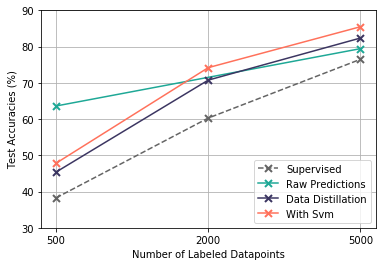

In [28]:
color_dict = {'supervised': {'color': '#646464', 'linestyle': '--'},
              'raw_predictions': {'color': '#1EA896', 'linestyle': '-'},
              'data_distillation': {'color': '#3B3561', 'linestyle': '-'},
              'with_svm': {'color': '#FF715B', 'linestyle': '-'}}
#color_map = ['#3626A7','#58BAA8','#0D0106','#456990','#A2D97E','#FB3640']
base_path = r'splits/cifar10'
method_list = ['supervised','raw_predictions','data_distillation','with_svm']
yeet = SplitExp(base_path,method_list)
yeet.plot_split_stuff('test_accuracies',color_dict)

In [29]:
class TableComp:
    def __init__(self,dataset_dir_dict,method_list):
        self.data_name_list = ['test_accuracies','train_accuracies','test_losses','train_losses','svm_train','svm_test']
        self.method_list = method_list
        self.dataset_dir_dict = dataset_dir_dict
        dataset_dict = {}
        for set_name,path in self.dataset_dir_dict.items():
            dataset_dict[set_name] = self.get_method_groups_dict(path)
        self.dataset_dict = dataset_dict
    def get_method_groups_dict(self,base_dir):
        method_groups_dict = {}
        for method in self.method_list:
            tmp_obj = GroupByMethod(base_dir,self.data_name_list,method,splits=False)
            if not tmp_obj.method_fold_dict:
                continue
            method_groups_dict[method] = tmp_obj
        return method_groups_dict
    
    def make_table(self,data_name):
        header = [set_name for set_name in self.dataset_dir_dict.keys()]
        header.insert(0,'')
        table_dict = {}
        for method in self.method_list:
            method_dict = {}
            for set_name,set_dict in self.dataset_dict.items():
                if not method in list(set_dict.keys()):
                    method_dict[set_name] = '-'
                    continue
                set_method_data = set_dict[method].method_data
                method_dict[set_name] = get_max(set_method_data[data_name])
            table_dict[method] = method_dict
        table_list = []
        table_list.append(header)
        for method in self.method_list:
            tmp_list = [table_dict[method][header[i]] for i in range(1,len(header))]
            fixed_meth_name = method.replace('_',' ')
            fixed_meth_name = fixed_meth_name.title()
            tmp_list.insert(0,fixed_meth_name)
            table_list.append(tmp_list)
        x = tabulate(table_list,headers='firstrow')
        print(x)
        return x, table_dict


dir_dict = {'CIFAR10': r'splits/cifar10/5000',
            'STL10': r'perc_10_STL10'}
method_list = ['supervised','raw_predictions','data_distillation','with_svm']
yeet = TableComp(dir_dict,method_list)
tab,t_dict = yeet.make_table('test_accuracies')

                     CIFAR10  STL10
-----------------  ---------  -------
Supervised             76.49  78.8
Raw Predictions        79.43  -
Data Distillation      82.36  -
With Svm               85.48  82.875


/opt/anaconda3/envs/mlproject_plot/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


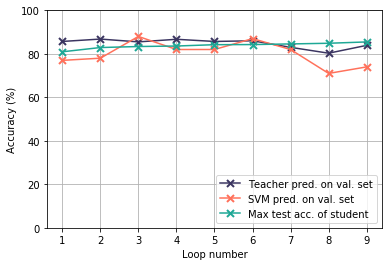

In [30]:
class SVM_Analysis:
    def __init__(self,base_dir,method_name):
        self.base_dir = base_dir
        self.method_name = method_name
        svm_name_list = ['svm_out','svm_true','svm_feat','svm_obj','svm_train','svm_test','svm_X','svm_y']
        self.data_name_list = ['test_accuracies','train_accuracies'] + svm_name_list
        self.method_group = GroupByMethod(self.base_dir,self.data_name_list,method_name,splits=False)
        self.data = self.method_group.method_data
    
    def get_teach_pred_acc(self):
        output_dict = self.data['svm_out']
        true_dict = self.data['svm_true']
        teach_pred_acc = []
        for loop,outputs in output_dict.items():
            means = np.mean(outputs,axis=1)
            pseudolabels = np.argmax(means,axis=1)
            true_labels = true_dict[loop]
            y_lab = [1 if true == pseudolabels[idx] else 0 for idx,true in enumerate(true_labels)]
            teach_pred_acc.append(100*np.sum(y_lab)/len(y_lab))
        return teach_pred_acc
    
    def plot_svm_w_stud(self):
        stud_test_accs = self.data['test_accuracies']
        max_stud_test_acc = [np.max(stud_test_accs['loop {}'.format(i)]) for i in range(len(list(stud_test_accs.keys())))]
        #print(max_stud_test_acc)
        svm_test = self.data['svm_test']
        svm_test_acc = [100*svm_test['loop {}'.format(i)]['accuracy'] for i in range(len(list(stud_test_accs.keys())))]
        teach_pred_acc = self.get_teach_pred_acc()
        x_tick_labels = [str.title(key) for key in stud_test_accs.keys()]
        diff = len(teach_pred_acc) - len(x_tick_labels)
        if diff > 0:
            for i in range(diff):
                teach_pred_acc.pop(-1)
        x_data = 1 + np.arange(len(x_tick_labels))
        plt.plot(x_data,teach_pred_acc,label='Teacher pred. on val. set',color='#3B3561',marker='x',markersize=7.,markeredgewidth=2)
        plt.plot(x_data,svm_test_acc,label='SVM pred. on val. set',color='#FF715B',marker='x',markersize=7.,markeredgewidth=2)
        plt.plot(x_data,max_stud_test_acc,label='Max test acc. of student',color='#1EA896',marker='x',markersize=7.,markeredgewidth=2)
        plt.xticks(1 + np.arange(len(x_data)))
        plt.xlabel('Loop number')
        plt.ylabel('Accuracy (%)')
        plt.legend(loc='lower right')
        plt.grid()
        plt.ylim(0,100)

        
bdir = r'CIFAR10_10_percent_with_1000_stats'
yeet = SVM_Analysis(bdir,'with_svm')
yeet.plot_svm_w_stud()

    

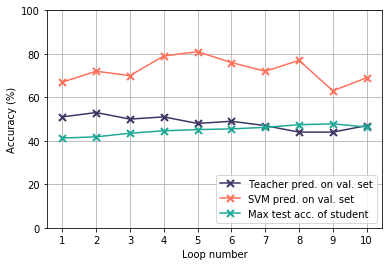

In [31]:
bdir = r'splits/cifar10/500'
yeet = SVM_Analysis(bdir,'with_svm')
yeet.plot_svm_w_stud()

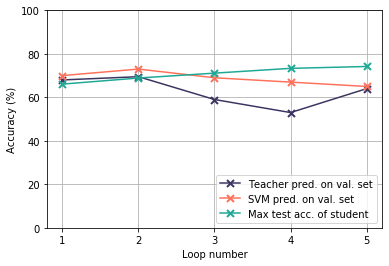

In [32]:
bdir = r'splits/cifar10/2000'
yeet = SVM_Analysis(bdir,'with_svm')
yeet.plot_svm_w_stud()

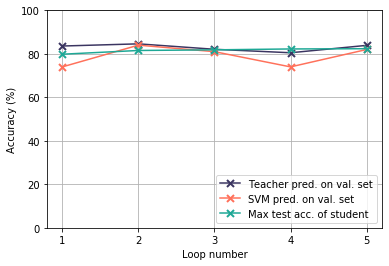

In [33]:
bdir = r'splits/cifar10/5000'
yeet = SVM_Analysis(bdir,'data_distillation')
yeet.plot_svm_w_stud()